In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')    
device

device(type='cuda')

In [3]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
ids = os.listdir(train_path)
os.makedirs('/kaggle/data_dir/',exist_ok=True)

In [4]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

In [5]:
for i in tqdm(ids):
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    mask=np.load(f'{train_path}/{i}/human_pixel_masks.npy')
    directory = f'/kaggle/data_dir/{i}/'
    os.makedirs(directory, exist_ok=True)
    np.save(os.path.join(directory, 'false.npy'), image)
    np.save(os.path.join(directory, 'mask.npy'), mask)

  0%|          | 0/20529 [00:00<?, ?it/s]

In [6]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.ids = os.listdir(self.path)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,idx):
        id = ids[idx]
        image = np.load(f'{self.path}/{id}/false.npy')
        mask = np.load(f'{self.path}/{id}/mask.npy')
        image = torch.from_numpy(image)
        image = torch.moveaxis(image,-1,0)
        mask = torch.from_numpy(mask)
        mask=torch.moveaxis(mask,-1,0)
        return image,mask.float()

In [7]:
train_dataset = CustomDataset('/kaggle/data_dir/')

In [8]:
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True)

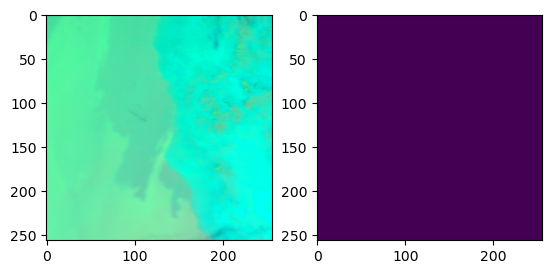

In [9]:
test_image , test_mask = next(iter(train_dataloader))
test_image = torch.moveaxis(test_image,1,-1)
test_mask = torch.moveaxis(test_mask,1,-1)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image[2])
fig[1].imshow(test_mask[2])

In [10]:
model = smp.UnetPlusPlus(encoder_name='resnet101',encoder_weights='imagenet',in_channels=3,classes=1,decoder_attention_type='scse',activation="sigmoid")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 112MB/s]  


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [11]:
def Dice_loss(pred, mask):
    
    smooth = 1e-6  # Smoothing factor to avoid division by zero
        
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

    

In [12]:
os.makedirs('/kaggle/working/savedmodel')

In [ ]:
learning_rate = 0.005
losses = []
epochs=50
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience = 4, factor = 0.31622776601, verbose = True)
best_score = 0
best_dice_epoch = 0
for epoch in range(epochs):
    batch_dice_score = 0
    net_dice_loss = 0
    if(epoch - best_dice_epoch > 15):
        print(f'early stopped due to no improvement in last 15 epochs')
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/last_run_epoch.pt')
        break
    cnt = 0
    for image , mask in tqdm(train_dataloader):
        image,mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = Dice_loss(pred,mask)
        loss.backward()
        optimizer.step()
        batch_dice_score += (1-loss)
        net_dice_loss +=loss
        cnt+=1
    net_dice_loss=net_dice_loss/cnt
    losses.append(net_dice_loss)
    print(f'at {epoch}th the dice loss is {net_dice_loss}')
    if(best_score<batch_dice_score):
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/{epoch}th_epoch.pt')
        torch.save(model,f'{epoch}th_model.pt')
        best_score = batch_dice_score
        best_dice_epoch = epoch
    

  0%|          | 0/1284 [00:00<?, ?it/s]

at 0th the dice loss is 0.6634836792945862


  0%|          | 0/1284 [00:00<?, ?it/s]

at 1th the dice loss is 0.5560027360916138


  0%|          | 0/1284 [00:00<?, ?it/s]

at 2th the dice loss is 0.5224629640579224


  0%|          | 0/1284 [00:00<?, ?it/s]